# Milestone 3 — Correlation & Metrics (SQL + Python)



In [1]:
# Setup: imports + data path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Local data path (update if different)
data_dir = Path(r"C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data")
athletes_fp = data_dir / "athlete_events.csv"
noc_fp = data_dir / "noc_regions.csv"

print("Using data path:", athletes_fp)
if not athletes_fp.exists():
    raise FileNotFoundError(f"athlete_events.csv not found at {athletes_fp}. Place the CSV in this folder and re-run the notebook.")
# load CSV into pandas
df = pd.read_csv(athletes_fp, low_memory=False)
print("Loaded CSV with shape:", df.shape)
# standard helpers
df['Year'] = df['Year'].astype(int)
df['is_medal'] = df['Medal'].notna()


Using data path: C:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\data\athlete_events.csv
Loaded CSV with shape: (271116, 15)


In [2]:
# create in-memory sqlite and table
conn = sqlite3.connect(':memory:')
df.to_sql('olympics', conn, index=False, if_exists='replace')

271116

## 1) Correlation preparation — extract numeric fields with SQL

In [3]:
query = """
SELECT Age, Height, Weight
FROM olympics
WHERE Age IS NOT NULL OR Height IS NOT NULL OR Weight IS NOT NULL
LIMIT 100000;
"""
num_sample = pd.read_sql_query(query, conn)
num_sample = num_sample.apply(pd.to_numeric, errors='coerce')
num_sample.dropna(inplace=True)
num_sample.head()

,Age,Height,Weight
0,24.0,180.0,80.0
1,23.0,170.0,60.0
4,21.0,185.0,82.0
5,21.0,185.0,82.0
6,25.0,185.0,82.0


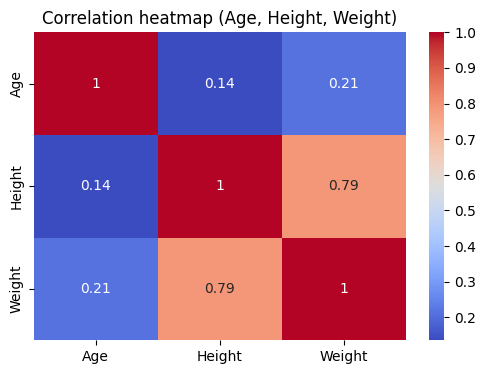

In [4]:
# correlation matrix
corr = num_sample[['Age','Height','Weight']].corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap (Age, Height, Weight)')
plt.show()

## 2) Logistic regression (Medal ~ Age + Height + Weight) — prepare data via SQL

In [5]:
# extract rows where Age/Height/Weight exist and Medal info
query = """
SELECT Medal IS NOT NULL AS Medal_Binary, Age, Height, Weight
FROM olympics
WHERE (Age IS NOT NULL AND Height IS NOT NULL AND Weight IS NOT NULL)
LIMIT 200000;
"""
model_df = pd.read_sql_query(query, conn)
model_df = model_df.dropna()
# convert boolean to int
model_df['Medal_Binary'] = model_df['Medal_Binary'].astype(int)
model_df.head()

,Medal_Binary,Age,Height,Weight
0,0,24.0,180.0,80.0
1,0,23.0,170.0,60.0
2,0,21.0,185.0,82.0
3,0,21.0,185.0,82.0
4,0,25.0,185.0,82.0


In [6]:
# fit logistic regression
import statsmodels.api as sm
X = sm.add_constant(model_df[['Age','Height','Weight']])
y = model_df['Medal_Binary']
logit = sm.Logit(y, X).fit(disp=False)
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:           Medal_Binary   No. Observations:               200000
Model:                          Logit   Df Residuals:                   199996
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                 0.01094
Time:                        21:25:26   Log-Likelihood:                -82277.
converged:                       True   LL-Null:                       -83187.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2741      0.141    -37.522      0.000      -5.550      -4.999
Age            0.0068      0.001      5.745      0.000       0.004       0.009
Height         0.0158      0.001     16.295      0.0

## 3) Medal Efficiency Index (MEI) and Age Performance Index (API) — computed using SQL aggregates

In [7]:
# MEI via SQL: medals per NOC and athletes per NOC
medals_sql = pd.read_sql_query("SELECT NOC, COUNT(Medal) AS MedalCount FROM olympics WHERE Medal IS NOT NULL GROUP BY NOC;", conn)
athletes_sql = pd.read_sql_query("SELECT NOC, COUNT(DISTINCT ID) AS NumAthletes FROM olympics GROUP BY NOC;", conn)
mei = medals_sql.merge(athletes_sql, on='NOC')
mei['MEI'] = mei['MedalCount']/mei['NumAthletes']
mei.sort_values('MEI', ascending=False).head()

,NOC,MedalCount,NumAthletes,MEI
139,URS,2503,2948,0.849050
47,GDR,1005,1360,0.738971
141,USA,5637,9653,0.583964
3,ANZ,29,53,0.547170
112,RUS,1165,2428,0.479819


In [8]:
# API via SQL: avg medalist age vs avg athlete age per sport
medalist_age = pd.read_sql_query("SELECT Sport, AVG(Age) AS AvgMedalistAge FROM olympics WHERE Medal IS NOT NULL GROUP BY Sport;", conn)
athlete_age = pd.read_sql_query("SELECT Sport, AVG(Age) AS AvgAthleteAge FROM olympics GROUP BY Sport;", conn)
api = medalist_age.merge(athlete_age, on='Sport')
api['API'] = api['AvgMedalistAge']/api['AvgAthleteAge']
api.sort_values('API', ascending=False).head()

,Sport,AvgMedalistAge,AvgAthleteAge,API
3,Archery,30.927900,27.935226,1.107129
23,Figure Skating,24.020779,22.232190,1.080450
55,Synchronized Swimming,23.809302,22.366851,1.064491
17,Cross Country Skiing,27.617268,26.006155,1.061951
18,Curling,33.302632,31.412527,1.060170


In [9]:
# save outputs
dir = Path.cwd()/'milestone3_summary'
dir.mkdir(exist_ok=True)
mei.to_csv(dir/'medal_efficiency_index.csv', index=False)
api.to_csv(dir/'age_performance_index.csv', index=False)
print('Saved MEI/API to', dir)

Saved MEI/API to c:\Users\Adithya\Downloads\Bibhu\SQL\athlete_events\notebooks\milestone3_summary
